# Reconstructing grid metrics for CMIP6 output

As far as I can see, the CMIP6 archive does not provide any cell metrics except for the tracer cell area and vertical thickness. They do however provide the cell corner points (vertices), which we can use to reconstruct the distances at the cell faces. We will reconstruct other distances by interpolation.

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
from xgcm import Grid

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [5]:
def read_data(uri):
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [6]:
# check the recreate_grids.py module in the notebooks folder
from recreate_grids import recreate_full_grid


## load some example data

In [7]:
u = read_data('gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/Omon/uo/gn/')
cellareao = read_data('gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Ofx/areacello/gn/')
# from a different run, but should be the same since its static?
thetao = read_data('gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/Omon/thetao/gn/')

ds = xr.merge([u, thetao, cellareao])
ds.coords['areacello'] = ds['areacello']

In [8]:
ds_new = recreate_full_grid(ds)
ds_new

<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, time: 1032, vertex: 4, x: 1440, x_right: 1440, y: 1080, y_right: 1080)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 -79.80674 -79.80527 ... 64.22252 64.11359
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon        (y, x) float32 -299.71835 -299.47037 ... 59.998463 59.99949
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    areacello  (y, x)

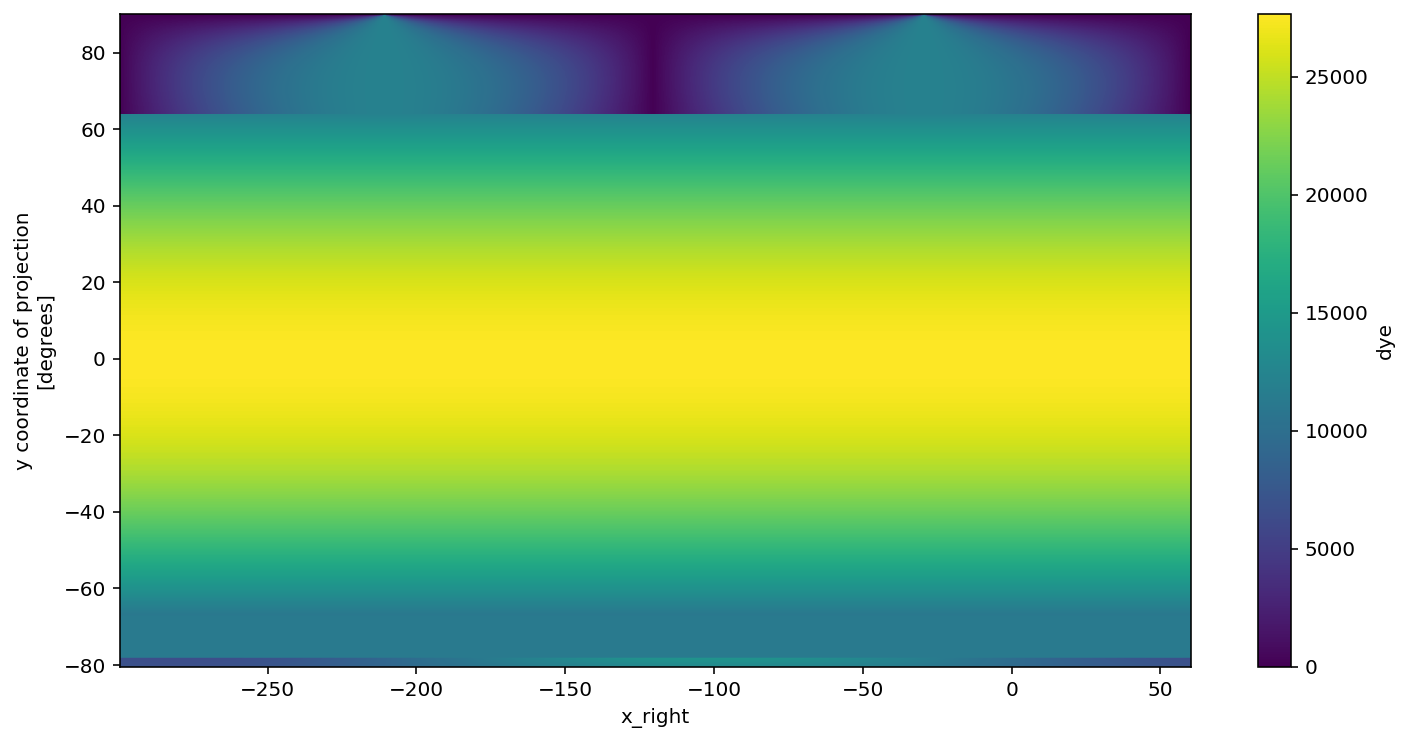

In [9]:
ds_new.dye.plot()

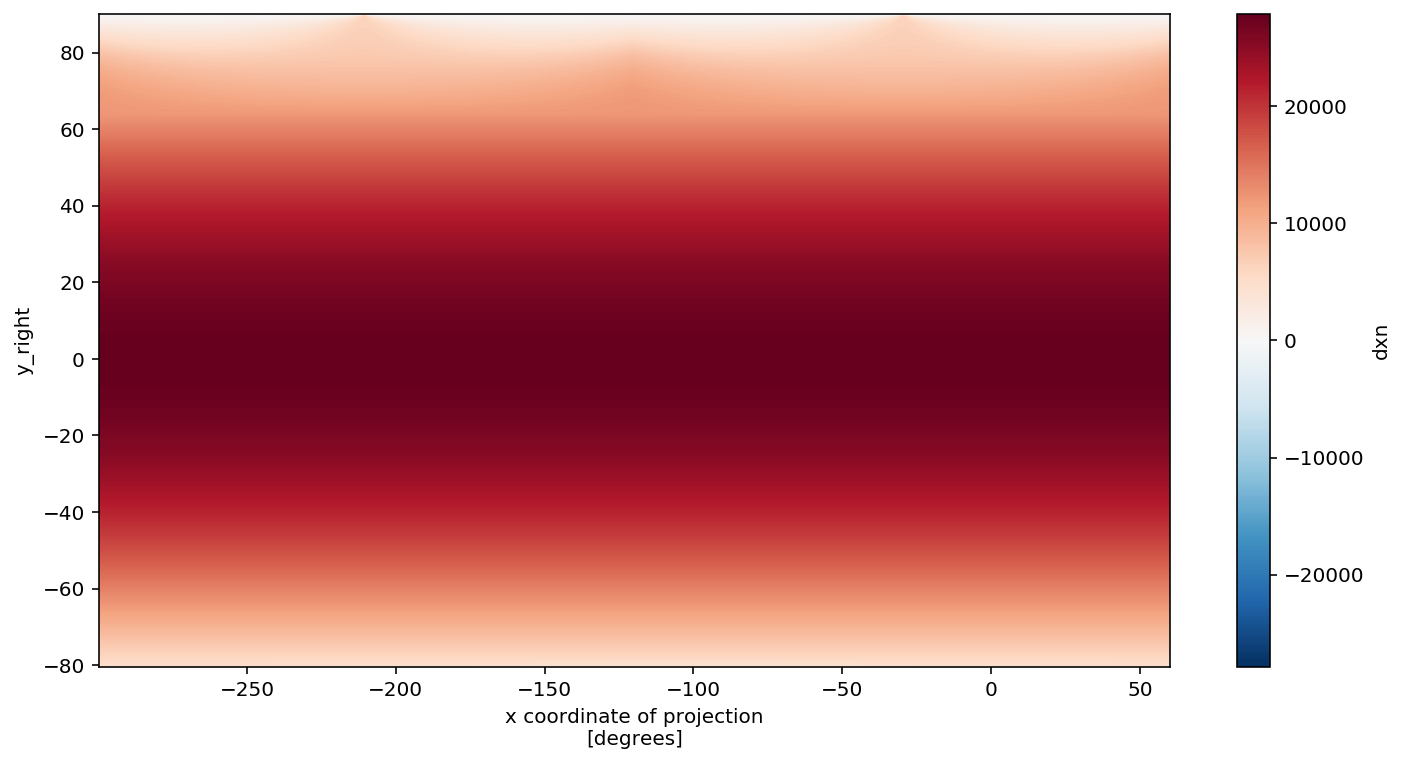

In [10]:
ds_new.dxn.plot()

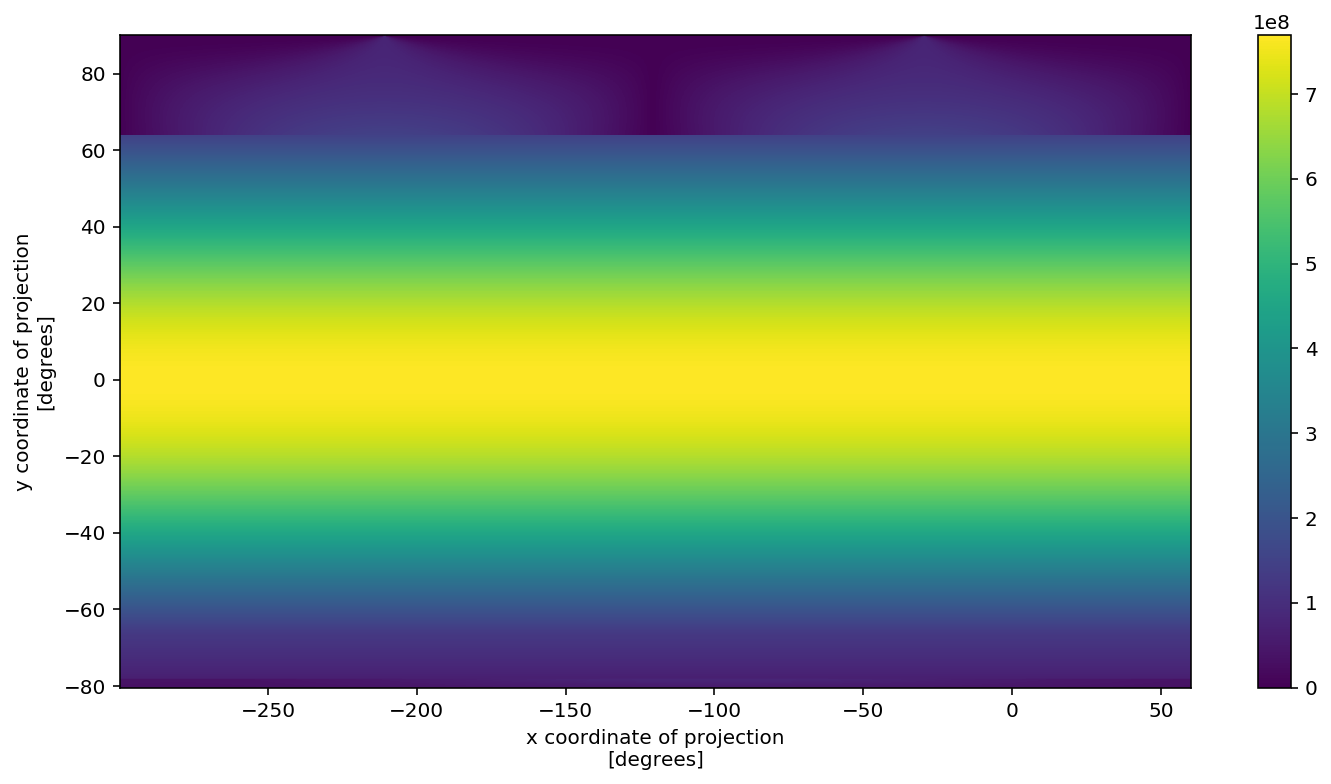

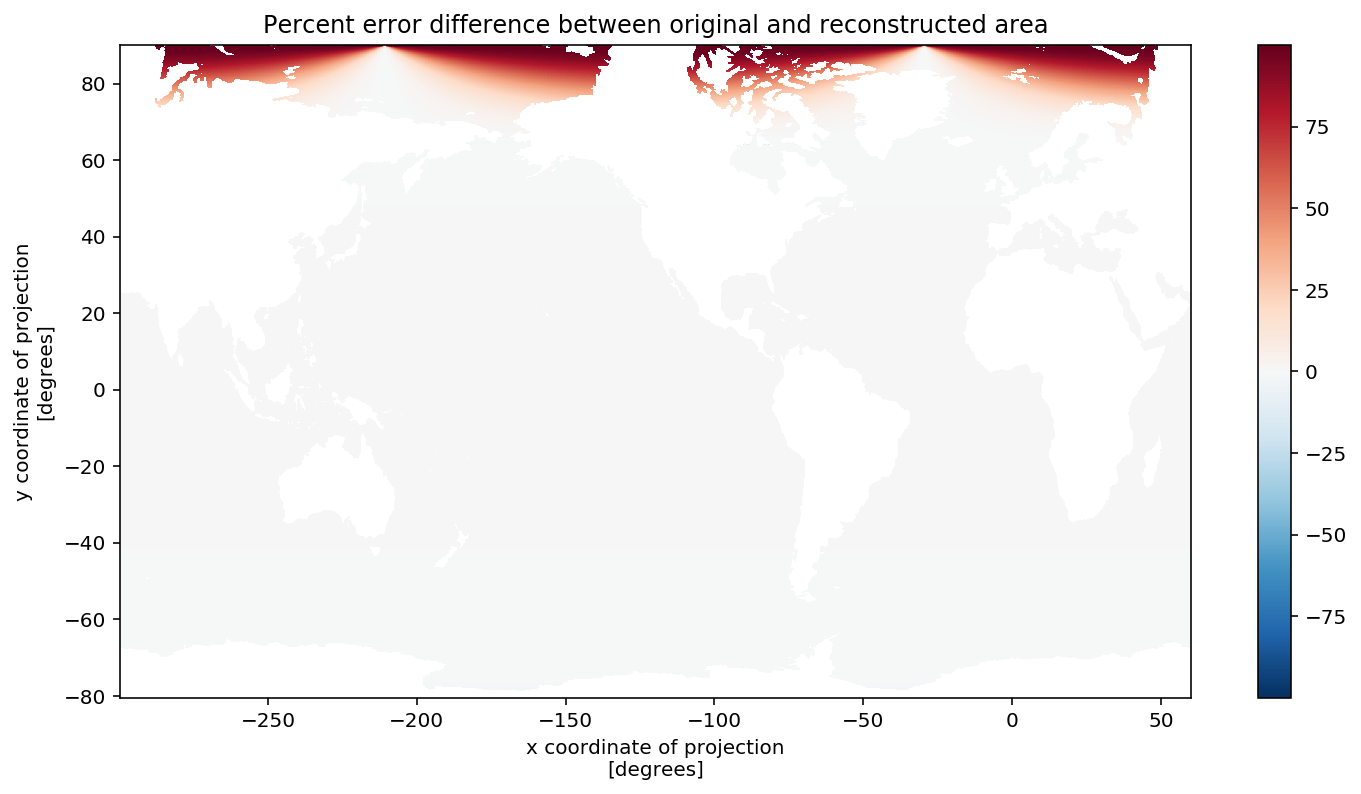

In [11]:
# compare inferred tracer area to the given
test_area = ds_new['dxt'] * ds_new['dyt']

plt.figure()
test_area.plot()

plt.figure()
((ds_new.areacello - test_area) / ds_new.areacello * 100).plot()
plt.title('Percent error difference between original and reconstructed area');

there are still some issues in the Arctic, but everywhere else looks fine. Not sure how to improve on this...

Sorry for the folks who want to compute budgets in the arctic, this will mess things up. For everyone else this looks ok to me! But that might also be different for other models...